In [1]:
regions = ['01']
scenarios = ['ssp126','ssp245', 'ssp370','ssp585']
vns = ['mass_annual', 'area_annual','runoff_fixed_monthly']
agg_fp = '/Volumes/LaCie/glacier_stats/'
normyear = 2000

group_dict_fullfn = '/Users/laurenoh/Desktop/research/PyGEM-analysis/rgi60_watershed_dict.csv'
group_cn = 'watershed'

group_min_glaciers = 50 # only include a given group if there is a critical number

merge_hma = True # option to merge HMA together (useful for watersheds or other groups that span multiple regions)

plot_norm = True # option to plot normalized figures or not

debug = True # Set True for extra print statements to check correct

In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter
import xarray as xr

try:
    import pygem
except:
    sys.path.append(os.getcwd() + '/../PyGEM/')
import pygem.pygem_modelsetup as modelsetup

In [3]:

ds_vn_dict = {'mass_annual':'glac_mass_annual',
              'area_annual':'glac_area_annual',
              'runoff_fixed_monthly':'glac_runoff_fixed_monthly'}
scenario_colordict = {'ssp119':'#081d58', 
                      'ssp126':'#1d91c0', 
                      'ssp245':'#7fcdbb', 
                      'ssp370':'#F47A20', 
                      'ssp585':'#ED2024'}
rgi_reg_dict = {'all':'Global',
                'global':'Global',
                1:'Alaska',
                2:'W Canada & US',
                3:'Arctic Canada North',
                4:'Arctic Canada South',
                5:'Greenland Periphery',
                6:'Iceland',
                7:'Svalbard',
                8:'Scandinavia',
                9:'Russian Arctic',
                10:'North Asia',
                11:'Central Europe',
                12:'Caucasus & Middle East',
                13:'Central Asia',
                14:'South Asia West',
                15:'South Asia East',
                16:'Low Latitudes',
                17:'Southern Andes',
                18:'New Zealand',
                19:'Antarctic & Subantarctic'
                }
scenario_namedict = {'rcp26':'RCP2.6',
                     'rcp45':'RCP4.5',
                     'rcp85':'RCP8.5',
                     'ssp119':'SSP1-1.9',
                     'ssp126':'SSP1-2.6',
                     'ssp245':'SSP2-4.5',
                     'ssp370':'SSP3-7.0',
                     'ssp585':'SSP5-8.5'}

In [4]:
# Group Dictionary
group_csv = pd.read_csv(group_dict_fullfn)
group_dict = dict(zip(group_csv.RGIId, group_csv[group_cn]))

In [5]:
for region in regions:
    
    for nvn, vn in enumerate(vns): #vn:'mass_annual', 'area_annual', 'runoff_fixed_monthly'
        print(vn)
        # Filepath
        ds_fp = agg_fp + '/' + vn + '/' + str(region) + '/'
        # Dataset variable name
        ds_vn = ds_vn_dict[vn] #glac_mass, glac_area
        
        for nscenario, scenario in enumerate(scenarios):
            print(scenario)
            # Filenames (lists enable batches which are used for runoff)
            ds_fns = []
            ds_fns_int = []
            for i in os.listdir(ds_fp):
                if not i.startswith("."):
                    if str(region) in i and vn in i and scenario in i:
                        ds_fns.append(i)
                        if 'Batch' in i:
                            ds_fns_int.append(int(i.split('-')[-2]))

            # Sort filenames
            if len(ds_fns_int) > 0:
                ds_fns = [x for _,x in sorted(zip(ds_fns_int, ds_fns))]

            # Load data (aggregate if necessary)
            for nfn, ds_fn in enumerate(ds_fns):
                if nfn == 0:
                    ds = xr.open_dataset(ds_fp + ds_fn)
                else:
                    ds_batch = xr.open_dataset(ds_fp + ds_fn)
                    ds = xr.concat((ds, ds_batch), dim='glacier')
        
            
            
            if nvn + nscenario == 0:
                glacno_list = [x.split('-')[1] for x in ds.RGIId.values]
                main_glac_rgi_reg = modelsetup.selectglaciersrgitable(glac_no=glacno_list)
                main_glac_rgi_reg[group_cn] = main_glac_rgi_reg.RGIId.map(group_dict)

            
                # unique groups
                groups_unique = list(main_glac_rgi_reg[group_cn].unique())
                groups_count = {}
                groups_idxs = {}
                for group in groups_unique:
                    main_glac_rgi_group = main_glac_rgi_reg.loc[main_glac_rgi_reg[group_cn] == group]
                    if main_glac_rgi_group.shape[0] > group_min_glaciers:
                        groups_count[group] = main_glac_rgi_group.shape[0]
                        groups_idxs[group] = list(main_glac_rgi_group.index.values)
                groups_unique = list(groups_count.keys())

            # Get time series for each group and GCM
            for ngroup, group in enumerate(groups_unique):
                ds_vn_values = ds[ds_vn].values
                ds_vn_values_group = ds_vn_values[:,groups_idxs[group],:].sum(1)

                if ngroup == 0:
                    groups_vn_values = ds_vn_values_group[np.newaxis,:,:]
                else:
                    groups_vn_values = np.concatenate((groups_vn_values, ds_vn_values_group[np.newaxis,:,:]), axis=0)

            # Create new xarray dataset based on groups
            ds_group = ds.copy()
            # create new variable
            ds_vn_group = ds_vn.replace('glac','group')
            ds_group[ds_vn_group] = ds_group[ds_vn]
            # drop the glacier variable
            ds_group = ds_group[ds_vn_group].sel(glacier=1, drop=True).to_dataset()
            # add back attributes that were lost in conversion to data array above
            ds_group.attrs = ds.attrs
            # create new coordinate for group
            ds_group['group'] = groups_unique
            # save data array that expands the dimension of the variables to include groups
            ds_group_array = ds_group[ds_vn_group].expand_dims(group=groups_unique)
            # update dataset variable with the data array
            ds_group[ds_vn_group] = ds_group_array
            # update the values
            ds_group[ds_vn_group].values = groups_vn_values


            # Export aggregated dataset
            if 'Batch' in ds_fn:
                # remove Batch from filename since now its aggregated
                ds_group_fn = ds_fn.replace('glac', group_cn).split('-')[0] + '-' + ds_fn.split('-')[1] + '.nc'
            else:
                ds_group_fn = ds_fn.replace('glac', group_cn)
            ds_group_fp = agg_fp + group_cn + '/' + vn + '/' + str(region).zfill(2) + '/'
            if not os.path.exists(ds_group_fp):
                os.makedirs(ds_group_fp)
            ds_group.to_netcdf(ds_group_fp + ds_group_fn)
      

mass_annual
ssp126
27108 glaciers in region 1 are included in this model run: ['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050'] and more
This study is focusing on 27108 glaciers in region [1]
ssp245
ssp370
ssp585
area_annual
ssp126
ssp245
ssp370
ssp585
runoff_fixed_monthly
ssp126
ssp245
ssp370
ssp585


In [6]:
ds_group

<xarray.Dataset>
Dimensions:                     (model: 12, time: 1212, group: 80)
Coordinates:
    Climate_Model               (model) object 'BCC-CSM2-MR' ... 'NorESM2-MM'
  * time                        (time) datetime64[ns] 2000-01-01 ... 2100-12-01
  * group                       (group) object 'Yukon' ... 'Colville'
Dimensions without coordinates: model
Data variables:
    group_runoff_fixed_monthly  (group, model, time) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    Region:       1 - Alaska
    source:       PyGEMv0.1.0
    institution:  Carnegie Mellon University
    history:      Created by David Rounce (drounce@cmu.edu) on September 11 2021
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

mass_annual
area_annual
runoff_fixed_monthly


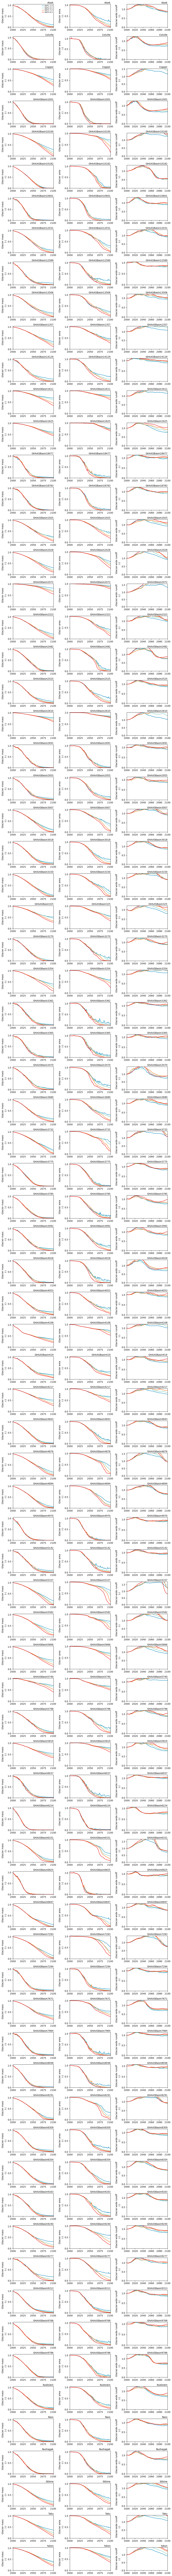

In [7]:
groups_unique = sorted(groups_unique)
for region in regions:
    
    fig, ax = plt.subplots(len(groups_unique), len(vns), squeeze=False, sharex=False, sharey=False, 
                       gridspec_kw = {'wspace':0.4, 'hspace':0.4})
    
    for nvn, vn in enumerate(vns):
        print(vn)
        
        # Filepath
        if type(region) is str:
            region_str = region
        else:
            region_str = str(region).zfill(2)
        ds_group_fp = agg_fp + group_cn + '/' + vn + '/' + region_str + '/'
        
        # Dataset variable name
        ds_vn = ds_vn_dict[vn].replace('glac', 'group')
        
        for ngroup, group in enumerate(groups_unique):
            for nscenario, scenario in enumerate(scenarios):
                # Filename
                for i in os.listdir(ds_group_fp):
                    if str(region) in i and vn in i and scenario in i:
                        ds_fn = i
     
                # Load data
                ds = xr.open_dataset(ds_group_fp + ds_fn)
                
                # Group idx
                group_idx = list(ds.group.values).index(group)

                # Aggregate data
                if 'annual' in ds_vn:
                    ds_med = ds[ds_vn].sel(group=group).median(dim='model')
                    ds_std = ds[ds_vn].sel(group=group).std(dim='model')
                    time_values = ds.year.values
                elif 'monthly' in ds_vn:
                    ds_med = ds[ds_vn].sel(group=group).resample(time='Y').sum('time').median('model')
                    ds_std = ds[ds_vn].sel(group=group).resample(time='Y').sum('time').std('model')
                    time_values = np.array([int(x) for x in pd.DatetimeIndex(ds_med.time.values).year])

                # Plot data
                normyear_idx = np.where(time_values == normyear)[0][0]
                ds_med_values = ds_med.values
                # Smooth runoff with 11-year running mean
                if 'runoff' in ds_vn:
                    ds_med_values = uniform_filter(ds_med_values, size=(11))

                if ngroup + nvn == 0:
                    label = scenario_namedict[scenario]
                else:
                    label = None

                if plot_norm:
                    ax[ngroup, nvn].plot(time_values, ds_med_values/ds_med_values[normyear_idx], 
                                         color=scenario_colordict[scenario], label=label)
                else:
                    ax[ngroup, nvn].plot(time_values, ds_med_values,
                                         color=scenario_colordict[scenario])

                # Bounds
                ax[ngroup, nvn].set_ylim(0)
                ax[ngroup, nvn].set_xlim(time_values[0], time_values[-1])
                
                # Add Labels
                try:
                    ylabel_wunits = ds[ds_vn].long_name + '\n(' + ds[ds_vn].units + ')'
                except:
                    ylabel_wunits = ds[ds_vn].long_name + '\n(' + ds[ds_vn].unit + ')'
                ylabel_norm = ds[ds_vn].long_name + '\n(-)'
                if plot_norm:
                    ax[ngroup, nvn].set_ylabel(ylabel_norm, size=10)
                else:
                    ax[ngroup, nvn].set_ylabel(ylabel_wunits, size=10)
                
                
                # Group label
                if nscenario == 0:
                    ax[ngroup, nvn].text(1, 1.01, group, size=10, horizontalalignment='right', 
                                         verticalalignment='bottom', transform=ax[ngroup,nvn].transAxes)
            # Add legend
            if ngroup + nvn == 0:
                ax[ngroup,nvn].legend(loc='upper right', fontsize=8, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                               handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)
                
    fig.set_size_inches(4*len(vns), 2.5*len(groups_unique))
    fig.savefig('Alaska_Graph.png')
    plt.show()

In [8]:
def peakwater(runoff, time_values, nyears):
    """Compute peak water based on the running mean of N years
    
    Parameters
    ----------
    runoff : np.array #find time series in numpy runoff by one watershed one scenario #just runoff and time/ get rid of model, watershed #maybe loop thru
        one-dimensional array of runoff for each timestep
        #index the ds_group to get index specific watershed for xarray
        #ds_group.loc[dict(group = 'Danube ... loop thru', model = 1)]
        #email david abt where to find scenario 
        #ds.loc[dict(space='IA')]
        
    time_values : np.array
        time associated with each timestep
        #index ds_gorup time
        # example: ds_group.coords['time'].values
        
    nyears : int
        number of years to compute running mean used to smooth peakwater variations
        
    Output
    ------
    peakwater_yr : int
        peakwater year
    peakwater_chg : float
        percent change of peak water compared to first timestep (running means used)
    runoff_chg : float
        percent change in runoff at the last timestep compared to the first timestep (running means used)
    """
    
    runningmean = uniform_filter(runoff, size=(nyears))
    peakwater_idx = np.where(runningmean == runningmean.max())[-1][0]
    peakwater_yr = time_values[peakwater_idx]
    peakwater_chg = (runningmean[peakwater_idx] - runningmean[0]) / runningmean[0] * 100
    runoff_chg = (runningmean[-1] - runningmean[0]) / runningmean[0] * 100
    return peakwater_yr, peakwater_chg, runoff_chg

(numpy.datetime64('2063-12-31T00:00:00.000000000'), 72.08468118017832, 29.114146603177417)
24864974191.177032
(numpy.datetime64('2070-12-31T00:00:00.000000000'), 60.005730557485315, 31.387623051417734)
20967278816.290447
(numpy.datetime64('2045-12-31T00:00:00.000000000'), 33.84753879773877, 0.20918119332395804)
22041135586.28514
(numpy.datetime64('2027-12-31T00:00:00.000000000'), 21.328475146502885, -11.280301300681183)
464384945.39444727
(numpy.datetime64('2026-12-31T00:00:00.000000000'), 18.782119012829742, -10.472269606116503)
1538711672.3948076
(numpy.datetime64('2027-12-31T00:00:00.000000000'), 26.040274021693804, -12.902006794261453)
4530462586.46483
(numpy.datetime64('2033-12-31T00:00:00.000000000'), 26.96768789441592, -12.987884791213189)
7615576431.567476
(numpy.datetime64('2023-12-31T00:00:00.000000000'), 27.400856174040822, -9.41436580274753)
52002683.86066862
(numpy.datetime64('2073-12-31T00:00:00.000000000'), 106.30620822429053, 81.2359484425136)
43412421375.60898


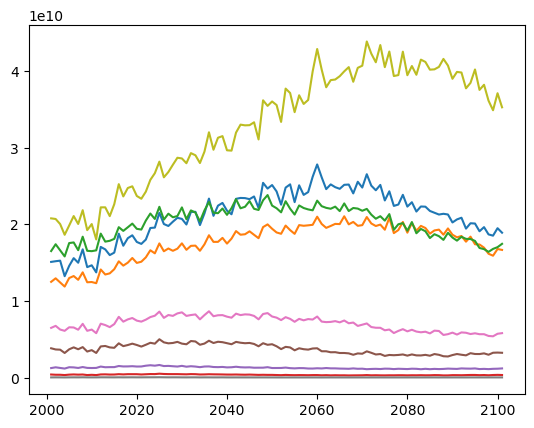

In [12]:
watershed = ['Yukon','Taku', 'Stikine','Nushagak','Nass','Kuskowin','Alsek','Colville','Copper']
colors = ['y','r','g','b','#A9A9A9','#FF1493']
ro = [1094253070.4733803,1281027513.975461,1693345728.8247046,2966593742.181963]
index = [63, 70, 45, 27, 26, 27, 33, 23, 73]
for i,w in enumerate(ws):
    dsr = ds_group['group_runoff_fixed_monthly']
    ds_gcmmean = dsr.mean('model')
    ds_runoff = ds_gcmmean.resample(time='y').sum()
    ds_runoff1 = ds_runoff.sel(group = w)
    ds_numpy = ds_runoff1.to_numpy()
    runoff, time_values, nyears = ds_numpy, ds_runoff.coords['time'].values, 11
    plt.plot(ds_runoff.coords['time'].values, ds_numpy, label = w)
    pw = peakwater(runoff, time_values, nyears) #peakwater_yr, peakwater_chg, runoff_chg
    print(pw)
    print(runoff[index[i]])

(numpy.datetime64('2063-12-31T00:00:00.000000000'), 72.08468118017832, 29.114146603177417)
2140045544209.0193
(numpy.datetime64('2070-12-31T00:00:00.000000000'), 60.005730557485315, 31.387623051417734)
1779188703577.646
(numpy.datetime64('2045-12-31T00:00:00.000000000'), 33.84753879773877, 0.20918119332395804)
2037702331441.287
(numpy.datetime64('2026-12-31T00:00:00.000000000'), 18.782119012829742, -10.472269606116503)
130331554329.29794
(numpy.datetime64('2027-12-31T00:00:00.000000000'), 26.040274021693804, -12.902006794261453)
377490964456.82544
(numpy.datetime64('2033-12-31T00:00:00.000000000'), 26.96768789441592, -12.987884791213189)
712803337732.9845
(numpy.datetime64('2073-12-31T00:00:00.000000000'), 106.30620822429053, 81.2359484425136)
3329429257181.9736


Text(0.5, 1.0, 'Alaska Glacier Runoff and Peakwater')

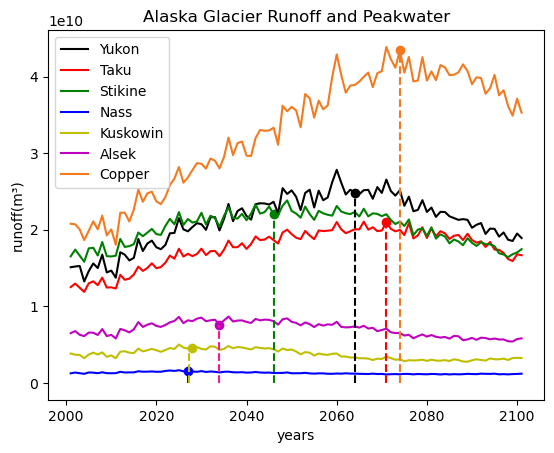

In [13]:
watershed = ['Yukon','Taku', 'Stikine','Nass','Kuskowin','Alsek','Copper']
#,'Colville','Nushagak'
colors = ['k','r','g','b','y','m','#F47A20']
for i,ws in enumerate(watershed):
    dsr = ds_group['group_runoff_fixed_monthly']
    ds_gcmmean = dsr.mean('model')
    ds_runoff = ds_gcmmean.resample(time='y').sum()
    ds_runoff1 = ds_runoff.sel(group = ws)
    ds_numpy = ds_runoff1.to_numpy()
    runoff, time_values, nyears = ds_numpy, ds_runoff.coords['time'].values, 11
    plt.plot(ds_runoff.coords['time'].values, ds_numpy, label = ws, color = colors[i])
    pw = peakwater(runoff, time_values, nyears) #peakwater_yr, peakwater_chg, runoff_chg
    print(pw)
    print(np.sum(ds_numpy))
    plt.legend()

a , b = [np.datetime64('2063-12-31T00:00:00.000000000')], [24864974191.177032] #Yukon
plt.scatter(a,b, color = 'k')
e, f =  [np.datetime64('2070-12-31T00:00:00.000000000')], [20967278816.290447] #Taku
plt.scatter(e,f,color='r')
i, j =  [np.datetime64('2045-12-31T00:00:00.000000000')], [22041135586.28514] #Stikine
plt.scatter(i,j,color='g')
# g, h = [np.datetime64('2027-12-31T00:00:00.000000000')],[464384945.39444727] #Nushagak
# plt.scatter(g,h)
c, d = [np.datetime64('2026-12-31T00:00:00.000000000')], [1538711672.3948076] #Nass
plt.scatter(c,d,color='b')
k, l = [np.datetime64('2027-12-31T00:00:00.000000000')], [4530462586.46483] #Koskoin
plt.scatter(k,l,color='y')
m, n = [np.datetime64('2033-12-31T00:00:00.000000000')], [7615576431.567476] #'Alsek'
plt.scatter(m,n,color='m')
# o, p = [np.datetime64('2023-12-31T00:00:00.000000000')], [52002683.86066862] #'Colville',
# plt.scatter(o,p)
q, r = [np.datetime64('2073-12-31T00:00:00.000000000')], [43412421375.60898] #Copper'
plt.scatter(q,r,color='#F47A20')
plt.vlines(x=np.datetime64('2063-12-31T00:00:00.000000000'), ymin=0, ymax=24864974191.177032, color='k', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2070-12-31T00:00:00.000000000'), ymin=0, ymax=20967278816.290447, color='r', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2045-12-31T00:00:00.000000000'), ymin=0, ymax=22041135586.28514, color='g', zorder=2, linestyle = {'dashed'})
# plt.vlines(x=np.datetime64('2027-12-31T00:00:00.000000000'), ymin=0, ymax=464384945.39444727, color='r', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2026-12-31T00:00:00.000000000'), ymin=0, ymax=1538711672.3948076, color='b', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2027-03-31T00:00:00.000000000'), ymin=0, ymax=4530462586.46483, color='y', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2033-12-31T00:00:00.000000000'), ymin=0, ymax=7615576431.567476, color='#FF1493', zorder=2, linestyle = {'dashed'})
# plt.vlines(x=np.datetime64('2023-12-31T00:00:00.000000000'), ymin=0, ymax=52002683.86066862, color='k', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2073-12-31T00:00:00.000000000'), ymin=0, ymax=43412421375.60898, color='#F47A20', zorder=2, linestyle = {'dashed'})

plt.xlabel("years")
plt.ylabel("runoff(m³)")
plt.title("Alaska Glacier Runoff and Peakwater")